In [220]:
"""
Caleb Ellington
C-NOTEARS hack
10/2/20

This is a hacked-together proof-of-concept for the contextualized no-tears method.
A list of all the bad design choices is kept below
==================================================

- batchsize limited to 1 for training reasons
- TODO: Make Xn the same shape as Wn to allow easy model.fit
"""

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import utils
utils.set_random_seed(1)

In [221]:
!python dataloader.py

archz = np.load('outputs/archetypes.npz')
W_k = archz['W_k']
e_k = archz['e_k']
samplez = np.load('outputs/samples.npz')
subtypes = samplez['subtypes']
W_n = samplez['W_n']
e_n = samplez['e_n'][:,:,np.newaxis]
X_n = samplez['X_n']
print(f"subtypes {subtypes.shape}, W_n {W_n.shape}, e_n {e_n.shape}, X_n {X_n.shape}")

subtypes (1000, 3), W_n (1000, 10, 10), e_n (1000, 50, 1), X_n (1000, 10, 10)


In [224]:
n, d, _ = W_n.shape
xn = X_n.shape[1]
cn = e_n.shape[1]
k = subtypes.shape[1]
batch_size = 1
epochs = 100
encoder_input_shape = (cn, 1)
encoder_output_shape = (k,)
dict_output_shape = (d, d)
tf_dtype = tf.dtypes.float32

print(f"n {n}, d {d}, xn {xn}, cn {cn}, k {k}")

n 1000, d 10, xn 10, cn 50, k 3


In [238]:
context = tf.keras.layers.Input(
    shape=encoder_input_shape, dtype=tf_dtype, name="C"
)

encoder = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(np.prod(encoder_output_shape), activation='softmax'),
])
encodings = encoder(context)
# encodings = tf.keras.layers.Lambda(lambda x: x, name="E")(encodings)

class Explainer(tf.keras.layers.Layer):
    def __init__(self, archetype_shape):
        super(Explainer, self).__init__()
        self.archetypes = self.add_weight("archetypes", 
                                          shape=archetype_shape)
        self.k, self.d, _ = archetype_shape
        
    def build(self, input_shapes):
        pass
        
    def call(self, subtype):
        tiled = tf.tile(subtype, (self.d*self.d, 1))
        transposed = tf.transpose(tiled)
        weights = tf.reshape(transposed, (subtype.shape[1], self.d, self.d))
        result = tf.math.reduce_sum(tf.math.multiply(weights, self.archetypes), axis=0)
        return result
        
explainer = Explainer(W_k.shape)
outputs = explainer(encodings)
# outputs = tf.keras.layers.Reshape(dict_output_shape, name="Y")(network)
model = tf.keras.models.Model(inputs=context, outputs=outputs)

In [239]:
# def loss_fn(subtypes, w_trues):
#     bsize = len(subtypes)
#     total_loss = tf.convert_to_tensor(0.0)
#     for i in tf.range(bsize):
#         subtype = subtypes[i]
#         w_true = w_trues[i]
#         total_loss += tf.reduce_sum(subtype)
#     return total_loss
#     d = w_true.shape[0]
#     W_pred = tf.reshape(tf.transpose(tf.tile(subtype, (d*d, 1))), (2, d, d)) * W_k
#     return tf.reduce_sum(tf.squared_difference(tf.zeros(W_true.shape), W_true))

# var_list_fn = lambda: model.trainable_weights
# for inval, outval in zip(e_n[:80], subtypes[:80]):
#   opt.minimize(loss_fn, var_list_fn)

def loss(x_true, w_pred):
    d = float(tf.shape(w_pred)[1])
    n = float(tf.shape(x_true)[0])
    l1_lambda = 1.0
    alpha = 1.0e2
    rho = 1.0e2
    h = tf.linalg.trace(tf.linalg.expm(w_pred * w_pred)) - d
    x_prime = tf.matmul(x_true, w_pred)
    mse = tf.square(tf.linalg.norm(x_true - x_prime))
    return 0.5 / n * mse \
            + l1_lambda * tf.norm(w_pred, ord=1) \
            + alpha * h + 0.5 * rho * h * h

opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
metrics = ['accuracy']
loss_fn = 'mse'

model.compile(loss=loss, 
             optimizer=opt, 
             metrics = metrics)
model.fit(e_n[:800], X_n[:800], batch_size=batch_size, epochs=epochs)

Epoch 1/100
800/800 [==============================] - 1s 987us/step - loss: 492.2352 - accuracy: 0.09850s - loss: 686.7396 - 
Epoch 2/100
800/800 [==============================] - 1s 979us/step - loss: 275.6503 - accuracy: 0.1034
Epoch 3/100
800/800 [==============================] - 1s 870us/step - loss: 255.4788 - accuracy: 0.1013
Epoch 4/100
800/800 [==============================] - 1s 889us/step - loss: 252.1045 - accuracy: 0.1007
Epoch 5/100
800/800 [==============================] - 1s 872us/step - loss: 241.9601 - accuracy: 0.0935
Epoch 6/100
800/800 [==============================] - 1s 916us/step - loss: 240.1981 - accuracy: 0.1019
Epoch 7/100
800/800 [==============================] - 1s 932us/step - loss: 237.3702 - accuracy: 0.1015
Epoch 8/100
800/800 [==============================] - 1s 928us/step - loss: 233.8383 - accuracy: 0.1005
Epoch 9/100
800/800 [==============================] - 1s 984us/step - loss: 233.9554 - accuracy: 0.1036
Epoch 10/100
800/800 [===========

In [240]:
y_pred = model.predict(e_n[900:901])
y_true = W_n[900:901][0]
print(f"mse| pred: {np.mean(np.sum(np.square(y_pred-y_true)))}, baseline: {np.mean(np.sum(np.square(np.zeros(y_pred.shape)-y_true)))}")

mse| pred: 6.162416797637318, baseline: 6.159427318412488


array([[[-1.13535693e-35, -8.60812849e-36,  2.13837075e+00,
          3.50283206e-01],
        [ 9.71582528e-36, -2.89748366e-35,  1.29655131e-09,
          9.97875122e-06],
        [-4.65190533e-05, -6.65372729e-01, -4.83426849e-18,
         -1.61679171e-04],
        [ 2.49212723e-35,  2.00855970e+00, -1.53988469e+00,
          1.20172888e-35]],

       [[ 1.58590230e-35,  6.94585722e-36, -1.22245669e+00,
         -1.96326649e+00],
        [ 1.04076594e-36,  2.92742174e-35, -9.10344744e-10,
          1.26473733e-05],
        [ 1.07025277e-04, -1.72486925e+00,  5.93750285e-18,
          2.78525258e-04],
        [-2.26224921e-35,  1.42876434e+00,  2.68954694e-01,
          1.35458505e-36]]], dtype=float32)

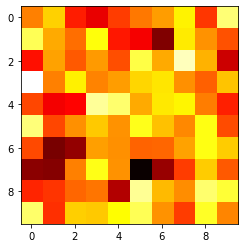

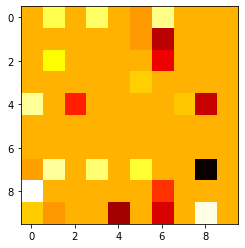

In [241]:
plt.imshow(y_pred, cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(y_true, cmap='hot', interpolation='nearest')
plt.show()

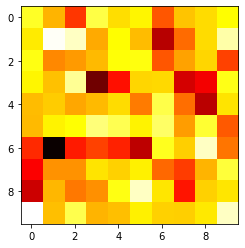

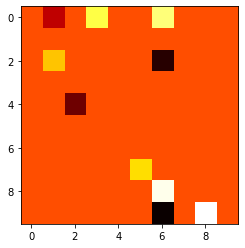

In [245]:
W_k_pred = explainer.trainable_variables[0].numpy()
plt.imshow(W_k_pred[1], cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(W_k[1], cmap='hot', interpolation='nearest')
plt.show()

In [169]:
y_pred

array([[ 4.1807475e-36,  2.7086915e-37,  2.1984136e-01, -9.7040731e-01],
       [ 4.7636650e-36,  4.2766542e-36,  3.6743997e-11,  1.1502136e-05],
       [ 4.1131778e-05, -1.2701867e+00,  1.3148005e-18,  8.9611669e-05],
       [-2.2191007e-36,  1.6775833e+00, -5.0730819e-01,  5.9304809e-36]],
      dtype=float32)